# Import Libraries

In [ ]:
import numpy as np
import seaborn as sns

from joblib import dump, load
from keras import layers, utils
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# Functions

In [ ]:
def add_noise(data, noise_factor, scale=1.0):
    data_noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return data_noisy
    #return np.clip(data_noisy, 0., 1.)

In [ ]:
def train_denoise_autoenc(autoencoder, epochs, noise_factor=0.3):
    for i in range(epochs):
        x_train_noisy = add_noise(x_train, noise_factor)
        x_valid_noisy = add_noise(x_valid, noise_factor)

        print("Epoch {}/{}".format(i+1, epochs))
        autoencoder.fit(x_train_noisy, x_train,
                        epochs=1, batch_size=256, shuffle=True,
                        validation_data=(x_valid_noisy, x_valid))

In [ ]:
def train_new_layer(encoder, model, epochs, noise_factor=0.3):
    for i in range(epochs):
        x_train_noisy = add_noise(x_train, noise_factor)
        x_valid_noisy = add_noise(x_valid, noise_factor)

        print("Epoch {}/{}".format(i+1, epochs))

        encoded_input = encoder(x_train_noisy)
        encoded_valid = encoder(x_valid_noisy)
        model.fit(encoded_input, encoded_input,
                  epochs=1, batch_size=256, shuffle=True,
                  validation_data=(encoded_valid, encoded_valid))

In [ ]:
def get_single_layer_autoencoder(encoding_dim, epochs=20, noise_factor=0.3):
    # 784 --> encoding_dim --> 784
    autoencoder = Sequential()
    autoencoder.add(layers.Dense(encoding_dim, activation='sigmoid', input_shape=(28*28,)))
    autoencoder.add(layers.Dense(28*28, activation='sigmoid'))
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanSquaredError()])
    train_denoise_autoenc(autoencoder, epochs, noise_factor)
    return autoencoder

In [ ]:
def get_deep_autoencoder(encoding_dims, epochs=50, noise_factor=0.3):
    base_model = get_single_layer_autoencoder(encoding_dims[0], epochs)
    output_layers = list()

    # Remove output layer and keep it
    output_layers.append(base_model.layers[-1])
    base_model.pop()

    for i in range(1, len(encoding_dims)):
        # Build another autoencoder
        new_autoenc = Sequential()
        new_autoenc.add(layers.Dense(encoding_dims[i], activation='sigmoid', input_shape=(encoding_dims[i-1],)))
        new_autoenc.add(layers.Dense(encoding_dims[i-1], activation='sigmoid'))
        new_autoenc.compile(optimizer='adam', loss='mse')

        # Train the new autoencoder
        print("\nTraining layer: ", i+1)
        train_new_layer(base_model, new_autoenc, epochs, noise_factor)

        # Add the new encoder
        base_model.add(new_autoenc.layers[0])

        # Keep the output layer
        output_layers.append(new_autoenc.layers[-1])

    # Add all output layers
    for i in range(len(output_layers)-1,-1,-1):
        base_model.add(output_layers[i])

    return base_model

# Load Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3, shuffle= True, random_state=0)

# Scale data from [0,255] to [0,1] so we can work as if it's a binary output
x_train = x_train.astype('float32') / 255.
x_valid = x_valid.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape each image from matrix to vector
x_train = x_train.reshape((len(x_train), 28*28))
x_valid = x_valid.reshape((len(x_valid), 28*28))
x_test = x_test.reshape((len(x_test), 28*28))

# Change label to one-hot encoding (will be used later for digit classifier)
y_train_cat = to_categorical(y_train, 10)
y_valid_cat = to_categorical(y_valid, 10)
y_test_cat = to_categorical(y_test, 10)

11493376/11490434 [==============================] - 0s 0us/step


# Experiments

In [ ]:
deep_2 = get_deep_autoencoder([256, 32])

In [ ]:
deep_2_clip = get_deep_autoencoder([256, 32])

Epoch 1/50
165/165 [==============================] - 4s 22ms/step - loss: 0.2717 - mean_squared_error: 0.0685 - val_loss: 0.2259 - val_mean_squared_error: 0.0529
Epoch 2/50
165/165 [==============================] - 4s 22ms/step - loss: 0.2031 - mean_squared_error: 0.0449 - val_loss: 0.1844 - val_mean_squared_error: 0.0387
Epoch 3/50
165/165 [==============================] - 4s 22ms/step - loss: 0.1720 - mean_squared_error: 0.0344 - val_loss: 0.1604 - val_mean_squared_error: 0.0305
Epoch 4/50
165/165 [==============================] - 4s 22ms/step - loss: 0.1520 - mean_squared_error: 0.0277 - val_loss: 0.1442 - val_mean_squared_error: 0.0252
Epoch 5/50
165/165 [==============================] - 4s 22ms/step - loss: 0.1382 - mean_squared_error: 0.0232 - val_loss: 0.1325 - val_mean_squared_error: 0.0214
Epoch 6/50
165/165 [==============================] - 4s 22ms/step - loss: 0.1281 - mean_squared_error: 0.0200 - val_loss: 0.1238 - val_mean_squared_error: 0.0187
Epoch 7/50
165/165 [==

In [ ]:
x_test_noisy = add_noise(x_test, 0.3)

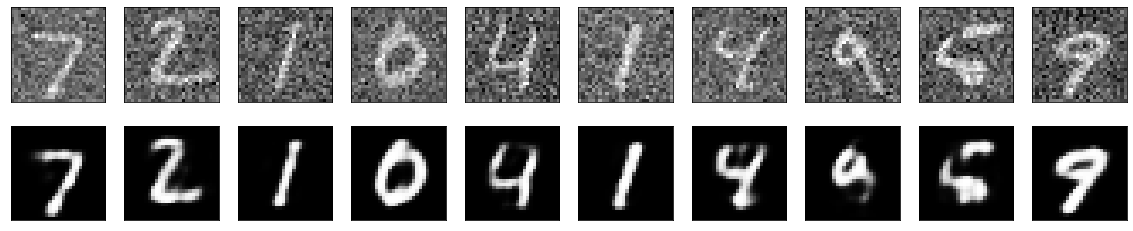

In [ ]:
num_img = 10
start_idx = 0
decoded_imgs = deep_2_clip(x_test_noisy)
plt.figure(figsize=(20, 4))
plt.gray()
for i in range(num_img):
    # Display original
    ax = plt.subplot(2, num_img, i + 1)
    plt.imshow(x_test_noisy[i+start_idx].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, num_img, i + 1 + num_img)
    decoded_img = decoded_imgs[i+start_idx].numpy()
    plt.imshow(decoded_img.reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
def energy_diff(model, x, x_star, n):
    points = np.linspace(x, x_star, num=n)
    model_out = model(points).numpy()
    sum = np.sum(model_out, axis=0)
    sum = (sum / n).reshape(1,784)
    return np.dot(sum, x_star - x)[0]

In [ ]:
def acc_ratio(model, x, x_star, n):
    e_diff = energy_diff(model, x, x_star, n)
    return np.exp(e_diff * -1)

In [ ]:
def is_accept(model, x, x_star, n):
    myu = np.random.uniform()
    alpha = acc_ratio(model, x, x_star, n)
    return myu <= alpha

(-0.5, 27.5, 27.5, -0.5)

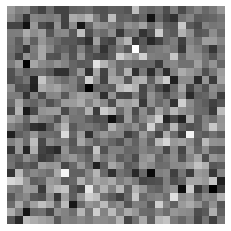

In [ ]:
# Try feeding a random image
plt.figure(figsize=(20, 4))
x_init = np.random.normal(loc=0, scale=1, size=(1,28*28))
plt.imshow(x_init.reshape(28, 28))
plt.axis('off')

In [ ]:
n_iter = 50
x = x_init
all = list()
acc = list()
rjct = list()
for i in range(n_iter):
    x = deep_2_clip(x.reshape(1,784)).numpy()
    x_star = deep_2_clip(add_noise(x, noise_factor=1)).numpy()
    all.append(x_star)
    if is_accept(deep_2_clip, x.reshape(784,), x_star.reshape(784,), n=10):
        x = x_star
        acc.append(x_star)
    else:
        rjct.append(x_star)

In [ ]:
len(rjct)

5

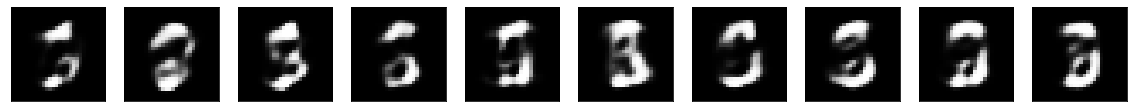

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(all[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

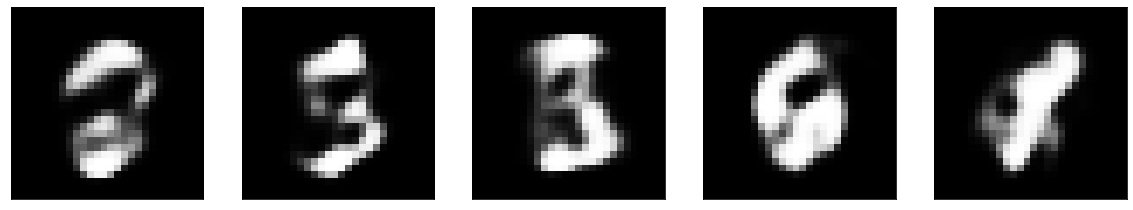

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(rjct[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

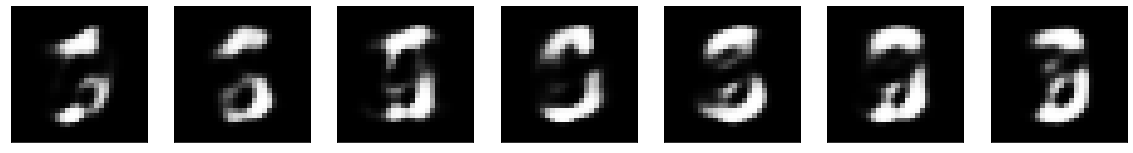

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(7):
    ax = plt.subplot(1, 7, i + 1)
    plt.imshow(acc[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

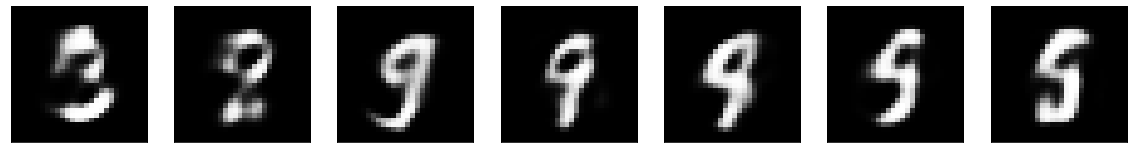

In [ ]:
plt.figure(figsize=(20, 4))
idx=[4,14,20,21,22,25,26]
for i in range(len(idx)):
    ax = plt.subplot(1, len(idx), i + 1)
    plt.imshow(result[idx[i]].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()